<a href="https://colab.research.google.com/github/BorsattoAndrea/API-project/blob/main/Homework2/Andrea/Sequence_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from keras.utils.vis_utils import plot_model
from scipy import stats
from collections import Counter

from tensorflow.keras.layers.experimental import RandomFourierFeatures

import pickle


from sklearn.model_selection import train_test_split
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
!unzip drive/MyDrive/ANNDL2/training_dataset_homework2.zip

Archive:  drive/MyDrive/ANNDL2/training_dataset_homework2.zip
  inflating: y_train.npy             
  inflating: x_train.npy             


In [5]:
X = np.load("x_train.npy")
y = np.load("y_train.npy")
X.shape, y.shape

((2429, 36, 6), (2429,))

In [6]:
label_mapping={
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine"

}

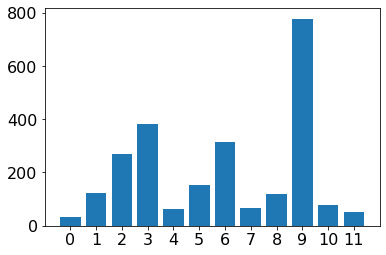

Counter({9: 777, 3: 381, 6: 313, 2: 270, 5: 153, 1: 123, 8: 120, 10: 77, 7: 68, 4: 62, 11: 51, 0: 34})


In [7]:
from collections import Counter
counter = Counter(y)
plt.bar(range(len(counter)), list(counter.values()), align='center')
plt.xticks(range(len(counter)), list(counter.keys()))
plt.show()
print(counter)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/10, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=seed) #1/9 * 9/10 = 1/10

In [9]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(class_weight="balanced",
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = {i : class_weights[i] for i in range(12)}
class_weights

{0: 5.397222222222222,
 1: 1.5568910256410255,
 2: 0.7710317460317461,
 3: 0.5291394335511983,
 4: 3.0550314465408803,
 5: 1.2551679586563307,
 6: 0.6555330634278003,
 7: 2.8913690476190474,
 8: 1.7599637681159421,
 9: 0.2624257158292815,
 10: 2.611559139784946,
 11: 4.376126126126126}

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1943, 36, 6), (243, 36, 6), (1943,), (243,))

# Create reference to old data


In [11]:
X_train_old = X_train.copy()
y_train_old = y_train.copy()

# Convert labels to categorical

In [14]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
y_val = tfk.utils.to_categorical(y_val)
X_train.shape,X_test.shape, X_val.shape, y_val.shape, y_train.shape, y_test.shape

((1943, 36, 6), (243, 36, 6), (243, 36, 6), (243, 12), (1943, 12), (243, 12))

In [15]:
def inspect_activity(x,y):
  data = pd. DataFrame(x, columns=['Column1', 'Column2','Column3', 'Column4','Column5', 'Column6'])
  axis = data.plot(subplots=True, figsize=(17, 9), title=label_mapping.get(np.argmax(y)))
  for ax in axis:
      ax.legend(loc='lower right')

In [19]:
X_train_shape = X_train.shape
X_test_shape = X_test.shape
X_val_shape = X_val.shape
X_train_reshaped = X_train.reshape((X_train_shape[0] * X_train_shape[1],X_train_shape[2]))
X_test_reshaped = X_test.reshape((X_test_shape[0] * X_test_shape[1],X_test_shape[2]))
X_val_reshaped = X_val.reshape((X_val_shape[0] * X_val_shape[1],X_val_shape[2]))

# Standardization

In [20]:
#normalize
# Apply MinMaxScaler to the useful features
scaler = RobustScaler()
scaler = scaler.fit(X_train_reshaped)
X_train_reshaped_norm = scaler.transform(X_train_reshaped)
X_test_reshaped_norm = scaler.transform(X_test_reshaped)
X_val_reshaped_norm = scaler.transform(X_val_reshaped)

X_train = X_train_reshaped_norm.reshape(X_train_shape)
X_test = X_test_reshaped_norm.reshape(X_test_shape)
X_val = X_val_reshaped_norm.reshape(X_val_shape)


In [21]:
import pickle
pickle.dump(scaler, open('scaler.pkl','wb'))

sc = pickle.load(open('scaler.pkl','rb'))

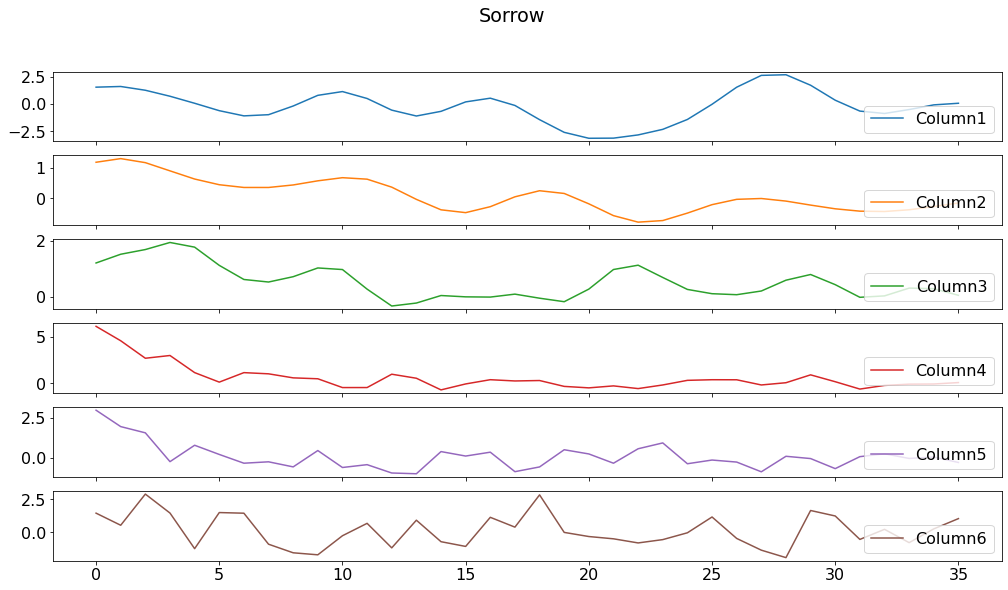

In [22]:
inspect_activity(X_train[0],y_train[0])

# Augmentation

In [23]:
!pip install tsaug
import tsaug

augs = []
#Time warp
X_aug_1 = tsaug.TimeWarp(n_speed_change=3, max_speed_ratio=3).augment(X_train)
#Pool
X_aug_2 = tsaug.Pool(size=2).augment(X_train)
#Drift
X_aug_3 = tsaug.Drift(max_drift=0.7, n_drift_points=5).augment(X_train)
#Crop + Resize
X_aug_4 = tsaug.Crop(size=18).augment(X_train)
X_aug_4 = tsaug.Resize(size=36).augment(X_aug_4)
#Add noise -> segment
X_aug_5 = tsaug.AddNoise(scale=0.1).augment(X_train)
#Convolve -> smoothin
X_aug_6 = tsaug.Convolve(window="flattop", size=11).augment(X_train)

augs.extend([X_aug_1,X_aug_2,X_aug_3,X_aug_4,X_aug_5,X_aug_6])
len(augs)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


6

In [24]:
X_train_aug = X_train.copy()
y_train_aug = y_train.copy()
for i in range(len(augs)):
    X_train_aug = np.concatenate((X_train_aug, augs[i]))
    y_train_aug = np.concatenate((y_train_aug, y_train))

In [25]:
#shuffle
train = list(zip(X_train_aug, y_train_aug))
random.shuffle(train)
X_train_aug, y_train_aug = zip(*train)
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)


In [26]:
def random_augmenter(X):
    X_shape = X.shape
    n = np.random.randint(6) +1
    chosen = np.random.choice([
        tsaug.TimeWarp(n_speed_change=3, max_speed_ratio=3),
        tsaug.Pool(size=2),
        tsaug.Drift(max_drift=0.7, n_drift_points=5),
        tsaug.Crop(size=18),
        tsaug.AddNoise(scale=0.1),
        tsaug.Convolve(window="flattop", size=11),
    ],n)
    for aug in chosen:
        X = aug.augment(X)
        if X.shape != X_shape:
            X = tsaug.Resize(size=36).augment(X)
            
    return X

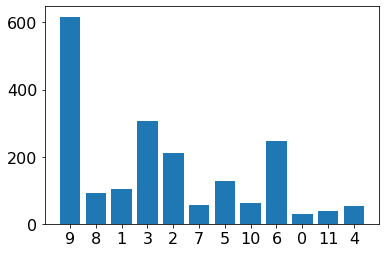

Counter({9: 617, 3: 306, 6: 247, 2: 210, 5: 129, 1: 104, 8: 92, 10: 62, 7: 56, 4: 53, 11: 37, 0: 30})


In [27]:
from collections import Counter
counter = Counter(np.argmax(y_train,axis=-1))
plt.bar(range(len(counter)), list(counter.values()), align='center')
plt.xticks(range(len(counter)), list(counter.keys()))
plt.show()
print(counter)

In [28]:
X_train_aug2 = X_train.copy()
y_train_aug2 = y_train.copy()
maxval = max(counter.values())
for i in range(12):
    val = X_train[np.argmax(y_train,axis=-1) == i].shape[0]
    curr = maxval - val
    X_class = X_train[np.argmax(y_train,axis=-1) == i].copy()
    if val < maxval:
        n = np.ceil(maxval / val)
        for _ in range(int(n)):
            if curr < val:
                aug = random_augmenter(X_class)[:curr]
                y_new = np.array([i]*curr)
                curr -= curr
            else:
                aug = random_augmenter(X_class)
                curr -= val
                y_new = np.array([i]*val)
            X_train_aug2 = np.concatenate((X_train_aug2, aug))
            y_new = tfk.utils.to_categorical(y_new,12)
            y_train_aug2 = np.concatenate((y_train_aug2, y_new))

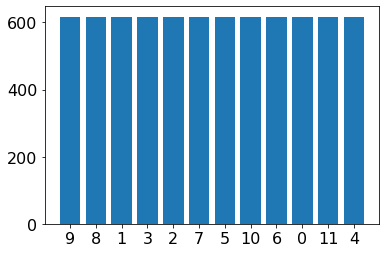

Counter({9: 617, 8: 617, 1: 617, 3: 617, 2: 617, 7: 617, 5: 617, 10: 617, 6: 617, 0: 617, 11: 617, 4: 617})


In [29]:
from collections import Counter
counter2 = Counter(np.argmax(y_train_aug2,axis=-1))
plt.bar(range(len(counter)), list(counter2.values()), align='center')
plt.xticks(range(len(counter)), list(counter2.keys()))
plt.show()
print(counter2)

In [30]:
#shuffle
train = list(zip(X_train_aug2, y_train_aug2))
random.shuffle(train)
X_train_aug2, y_train_aug2 = zip(*train)
X_train_aug2 = np.array(X_train_aug2)
y_train_aug2 = np.array(y_train_aug2)

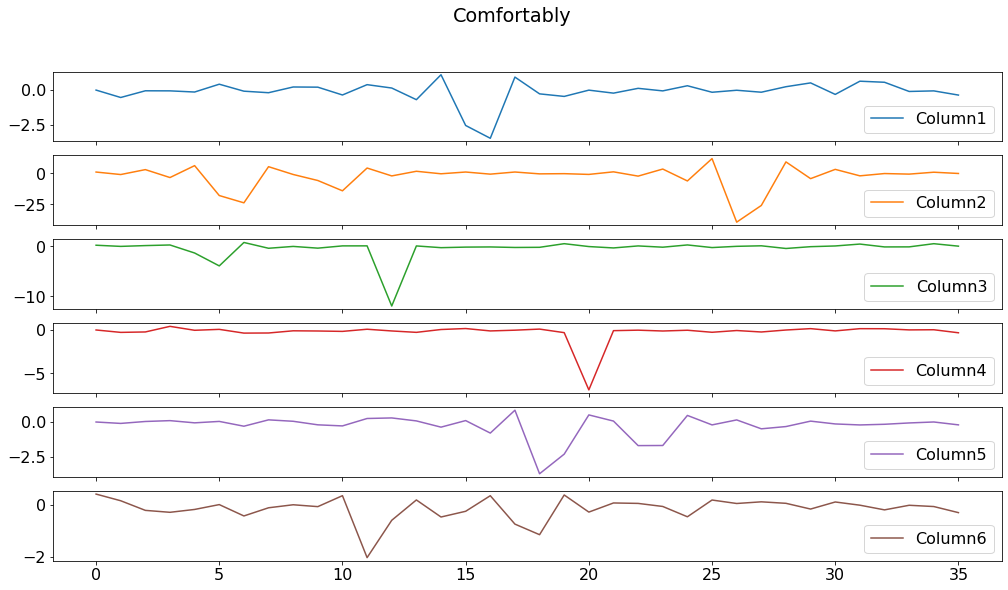

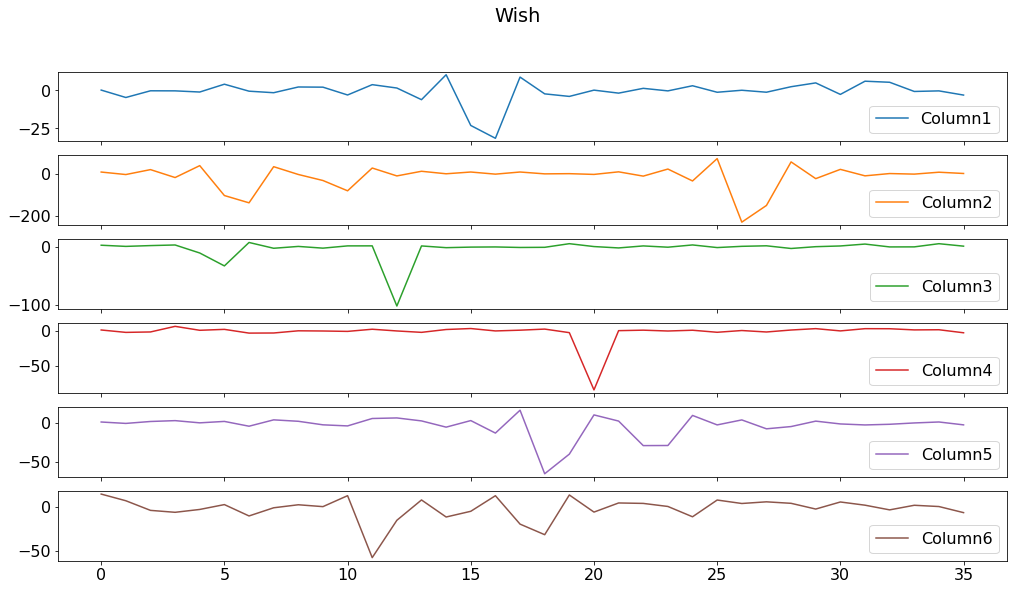

In [35]:
sample = random.randint(0, 1943)
inspect_activity(X_train[sample],y_train[sample])
inspect_activity(X_train_old[sample],y_train_old[sample])

# Training

In [ ]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 32
epochs = 200

In [ ]:
X_train.shape

(7404, 36, 6)

LSTM

In [ ]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)
    lstm = tfkl.LSTM(128)(dropout)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier

    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model
     

In [ ]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 36, 128)           69120     
                                                                 
 dropout_2 (Dropout)         (None, 36, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 12)                1548  

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(7404, 36, 6)
(7404, 12)
(243, 36, 6)
(243, 12)


In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = epochs,
    validation_data=(X_val, y_val),
    #class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
463/463 [==============================] - 8s 10ms/step - loss: 0.9184 - accuracy: 0.6830 - val_loss: 1.5037 - val_accuracy: 0.4486 - lr: 0.0010
Epoch 2/200
463/463 [==============================] - 4s 8ms/step - loss: 0.5148 - accuracy: 0.8250 - val_loss: 1.3048 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 3/200
463/463 [==============================] - 4s 8ms/step - loss: 0.4300 - accuracy: 0.8586 - val_loss: 1.4156 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 4/200
463/463 [==============================] - 4s 8ms/step - loss: 0.3835 - accuracy: 0.8734 - val_loss: 1.2798 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 5/200
463/463 [==============================] - 4s 8ms/step - loss: 0.3542 - accuracy: 0.8845 - val_loss: 1.4056 - val_accuracy: 0.5720 - lr: 0.0010
Epoch 6/200
463/463 [==============================] - 4s 8ms/step - loss: 0.3191 - accuracy: 0.8947 - val_loss: 1.2897 - val_accuracy: 0.6008 - lr: 0.0010
Epoch 7/200
463/463 [==============================] - 4s 8ms/s

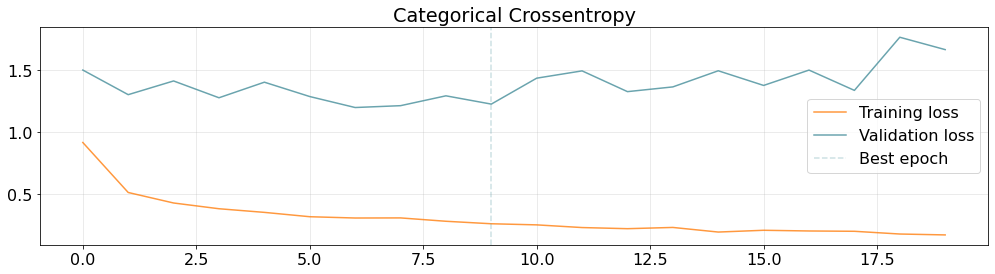

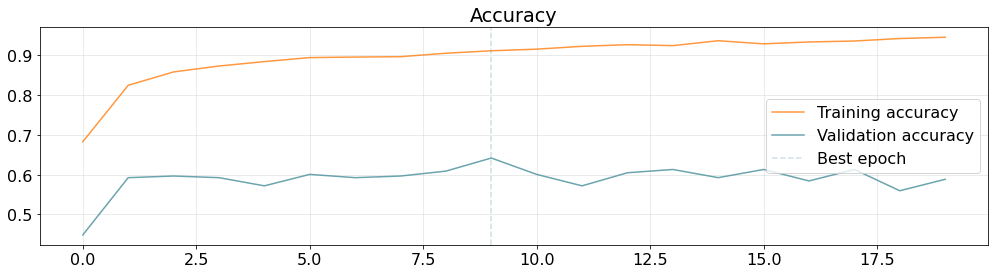

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

8/8 [==============================] - 0s 7ms/step
Accuracy: 0.716
Precision: 0.6411
Recall: 0.6401
F1: 0.6026


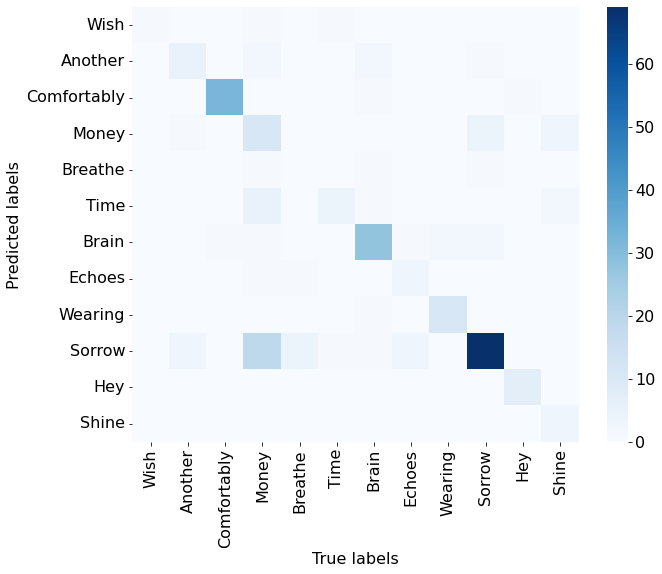

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_test)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Bidirectional LSTM

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(64))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(64, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
from keras.regularizers import L1L2
#regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 128)          36352     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 12)                780   

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 4,
    epochs = epochs,
    validation_data=(X_val,y_val),
    #class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
1851/1851 [==============================] - 29s 13ms/step - loss: 0.9381 - accuracy: 0.6745 - val_loss: 1.5129 - val_accuracy: 0.4691 - lr: 0.0010
Epoch 2/200
1851/1851 [==============================] - 25s 13ms/step - loss: 0.5833 - accuracy: 0.7923 - val_loss: 1.4491 - val_accuracy: 0.5432 - lr: 0.0010
Epoch 3/200
1851/1851 [==============================] - 23s 12ms/step - loss: 0.5113 - accuracy: 0.8209 - val_loss: 1.2548 - val_accuracy: 0.5885 - lr: 0.0010
Epoch 4/200
1851/1851 [==============================] - 23s 13ms/step - loss: 0.4365 - accuracy: 0.8451 - val_loss: 1.2340 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 5/200
1851/1851 [==============================] - 23s 12ms/step - loss: 0.3973 - accuracy: 0.8616 - val_loss: 1.2991 - val_accuracy: 0.5679 - lr: 0.0010
Epoch 6/200
1851/1851 [==============================] - 23s 12ms/step - loss: 0.3677 - accuracy: 0.8691 - val_loss: 1.4130 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 7/200
1851/1851 [=================

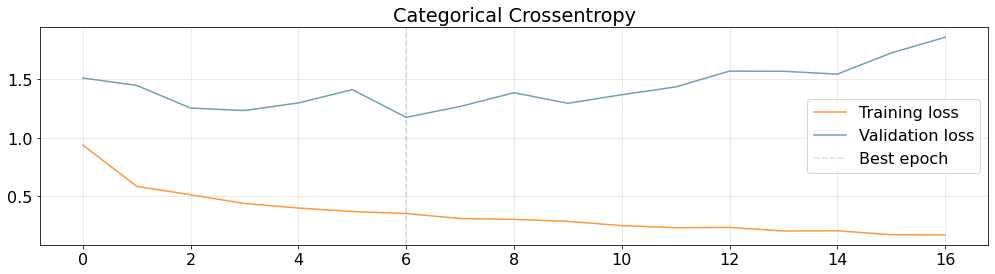

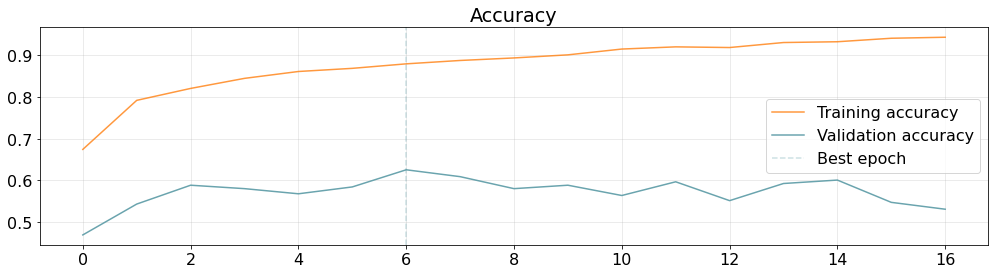

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

8/8 [==============================] - 1s 6ms/step
Accuracy: 0.6296
Precision: 0.465
Recall: 0.4798
F1: 0.4629


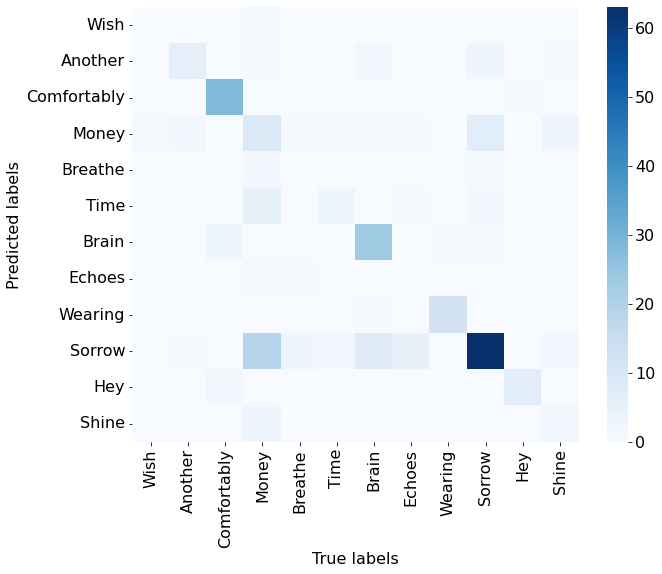

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_test)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

1D Conv

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model
     

In [ ]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           2432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_4 (Dropout)         (None, 128)               0     

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
463/463 [==============================] - 4s 5ms/step - loss: 5.6502 - accuracy: 0.2505 - val_loss: 2.9252 - val_accuracy: 0.3580 - lr: 0.0010
Epoch 2/200
463/463 [==============================] - 2s 4ms/step - loss: 1.9885 - accuracy: 0.3840 - val_loss: 2.7777 - val_accuracy: 0.3457 - lr: 0.0010
Epoch 3/200
463/463 [==============================] - 2s 4ms/step - loss: 1.8288 - accuracy: 0.4539 - val_loss: 2.4052 - val_accuracy: 0.3868 - lr: 0.0010
Epoch 4/200
463/463 [==============================] - 2s 4ms/step - loss: 1.6244 - accuracy: 0.4999 - val_loss: 2.2924 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 5/200
463/463 [==============================] - 2s 4ms/step - loss: 1.4208 - accuracy: 0.5608 - val_loss: 2.9101 - val_accuracy: 0.3745 - lr: 0.0010
Epoch 6/200
463/463 [==============================] - 2s 4ms/step - loss: 1.4178 - accuracy: 0.5628 - val_loss: 2.4620 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 7/200
463/463 [==============================] - 2s 4ms/st

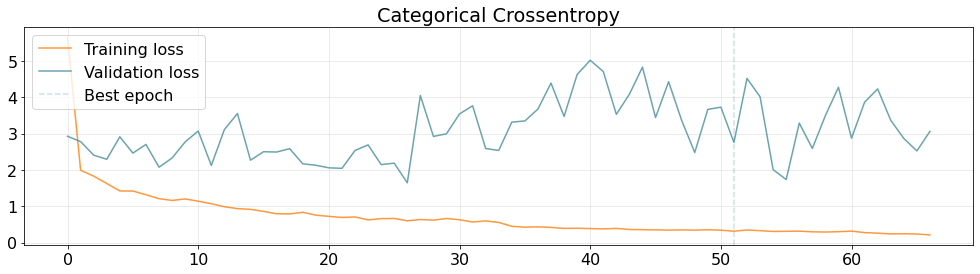

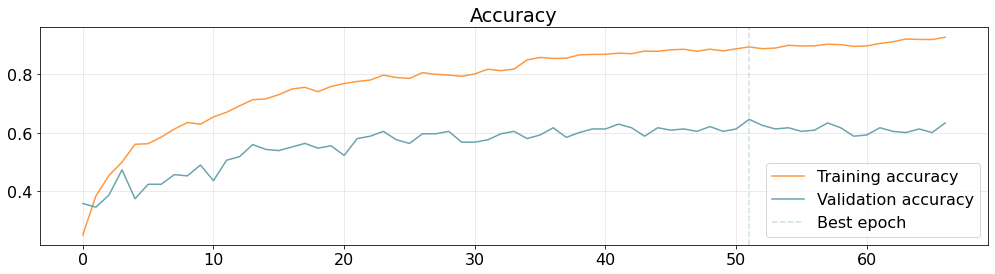

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

8/8 [==============================] - 0s 2ms/step
Accuracy: 0.716
Precision: 0.6411
Recall: 0.6401
F1: 0.6026


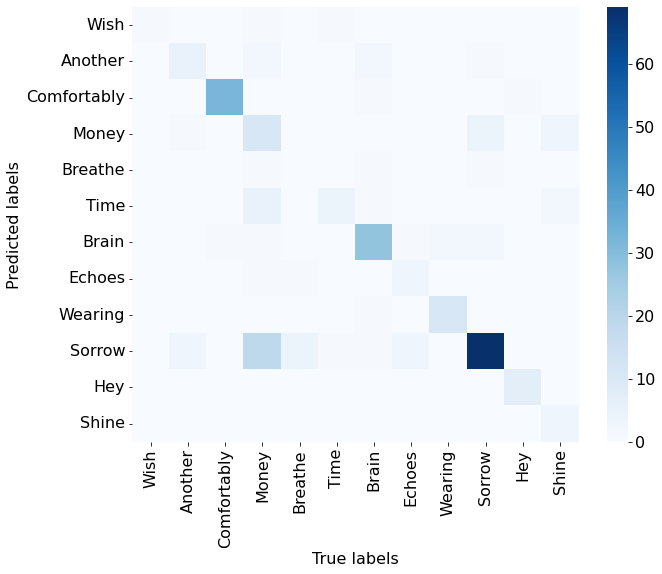

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_test)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.values()), yticklabels=list(label_mapping.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()